# 1. Collect and label image data

In [2]:
import os 
import time
import uuid     # To create nique uniform identifier for collected images
import cv2      # For access camera sensors for image data collection

## 1.1 Collect the image data

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In the code block below, we will capture a number of images from the camera. There will be a little delay between each image capture for the user to make slight adjustment to their faces and postures.

In [15]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_EXPOSURE,-6)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    
    ret, frame = cap.read()

    if not ret:
        print("There are some errors in the capture process")
        # break

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('Frame', frame)
    time.sleep(1.0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 1.2 Label the image data

In [ ]:
!labelme 

2025-02-12 17:58:49.556 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\mnguyen6\.labelmerc


# 2. Review Dataset and Build Image Loading Function 

## 2.1 Import TF and dependencies

In [4]:
import tensorflow as tf 
import json         # For parsing the json label files
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'{len(gpus)} GPUs found')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1 GPUs found


In [7]:
tf.test.is_gpu_available()

True

## 2.3 Load Image in to TF Data Pipeline

In [8]:
images = tf. data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [9]:
images.as_numpy_iterator().next()

b'data\\images\\28b03f66-e98b-11ef-8d00-4cd717a70326.jpg'

Helper function to load the images from the file path into an image generator object. This function first read the byte-encoded images and convert them to array of image pixel values.

This function is later [mapped]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map)) on to the generator with the image path to load the images

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
# Look at one image sample and its shape
print('Image pixel values \n',images.as_numpy_iterator().next())
print('\nImage shape ', images.as_numpy_iterator().next().shape)

Image pixel values 
 [[[242 249 241]
  [242 249 241]
  [242 250 239]
  ...
  [235 238 229]
  [237 238 230]
  [237 237 229]]

 [[241 248 240]
  [242 249 241]
  [242 250 239]
  ...
  [232 238 228]
  [235 236 228]
  [234 234 226]]

 [[238 248 239]
  [239 249 240]
  [240 250 241]
  ...
  [233 243 232]
  [238 241 234]
  [242 241 236]]

 ...

 [[231 248 240]
  [230 247 239]
  [228 245 239]
  ...
  [222 234 222]
  [219 230 216]
  [215 226 212]]

 [[228 247 241]
  [227 246 240]
  [225 244 238]
  ...
  [227 237 226]
  [222 233 219]
  [218 229 215]]

 [[227 246 240]
  [226 245 239]
  [225 244 238]
  ...
  [231 241 230]
  [227 238 224]
  [224 235 221]]]

Image shape  (480, 640, 3)


In [13]:
type(images)  # This is a tensorflow dataset object 

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 Display raw data with Matplotlib

Group the images in the generator into small batches of 4 images => [Data batching]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map))

In [14]:
image_generator = images.batch(4).as_numpy_iterator()    # Batch the images into batches of 4

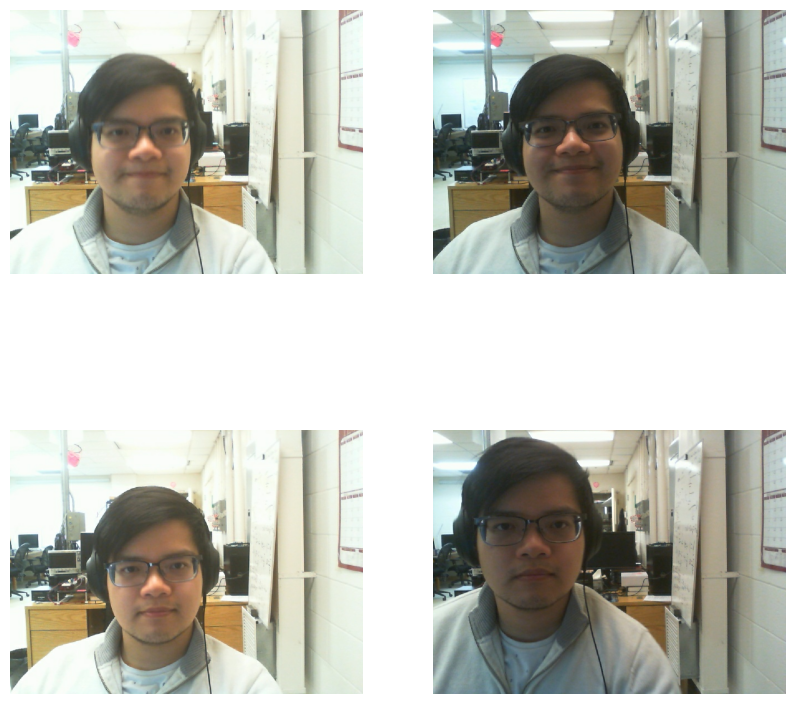

In [15]:
plot_images = image_generator.next()    # Get the next batch of images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for idx, image in enumerate(plot_images):
    ax[idx%2, idx//2].imshow(image)
    ax[idx%2, idx//2].axis('off')

plt.show()

# 3. Partition Unaugmented Data

In [ ]:
def image_data_split(train_dir, val_dir, desired_split=0.8, test_dir=None, seed=42):
    """
    Function to split the data into training and validation sets
    """
    # Get the list of all the images and labels in the base data directory
    all_images = tf.data.Dataset.list_files(os.path.join(train_dir,'images','/*.jpg'), shuffle=False)
    # Count the total number of images
    num_images = len(all_images)
    # Shuffle the images
    all_images = all_images.shuffle(num_images, seed=seed)
    # Split the images into training and validation sets
    train_images = all_images.take(int(desired_split*num_images))
    val_images = all_images.skip(int(desired_split*num_images))
    # If test directory is provided
    if test_dir:
        test_images = tf.data.Dataset.list_files(test_dir + '/*.jpg', shuffle=False)
        return train_images, val_images, test_images
    return train_images, val_images

In [27]:
label_dir = 'data\\labels'
os.path.join(label_dir,'*.json')

'data\\labels\\*.json'

In [ ]:
label_dir = 'data\\labels'
all_labels = tf.data.Dataset.list_files(os.path.join(label_dir,'*.json'), shuffle=False)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset